In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 定义导入函数
class image_dataset_import(Dataset):
    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # 遍历每个类别文件夹
        for category in ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']:
            category_path = os.path.join(root_dir, category)
            images_path = os.path.join(category_path, 'images')
            masks_path = os.path.join(category_path, 'masks')
            
            # 遍历images文件夹下的所有图片
            for img_name in os.listdir(images_path):
                img_path = os.path.join(images_path, img_name)
                mask_name = img_name  # 假设掩模和图像文件名相同
                mask_path = os.path.join(masks_path, mask_name)
                self.samples.append((img_path, mask_path, category))

    def __len__(self):
        return len(self.samples) #返回样本量

    def __getitem__(self, idx):
        img_path, mask_path, label = self.samples[idx]
        image = Image.open(img_path).convert('L')  # L:灰度图像 RGB:彩色图像
        mask = Image.open(mask_path).convert('L')  

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask, label

# 定义转换操作
transform = transforms.Compose([
    transforms.Resize((256, 256)), #图片尺寸
    transforms.ToTensor(), #转换为Pytorch张量对象
])

In [5]:
# 导入数据集
dataset = image_dataset_import(root_dir='D:/OneDrive - [DMR] Team/Master/工作/jupyter/VIT_example/vit_covid/dataset', transform=transform)

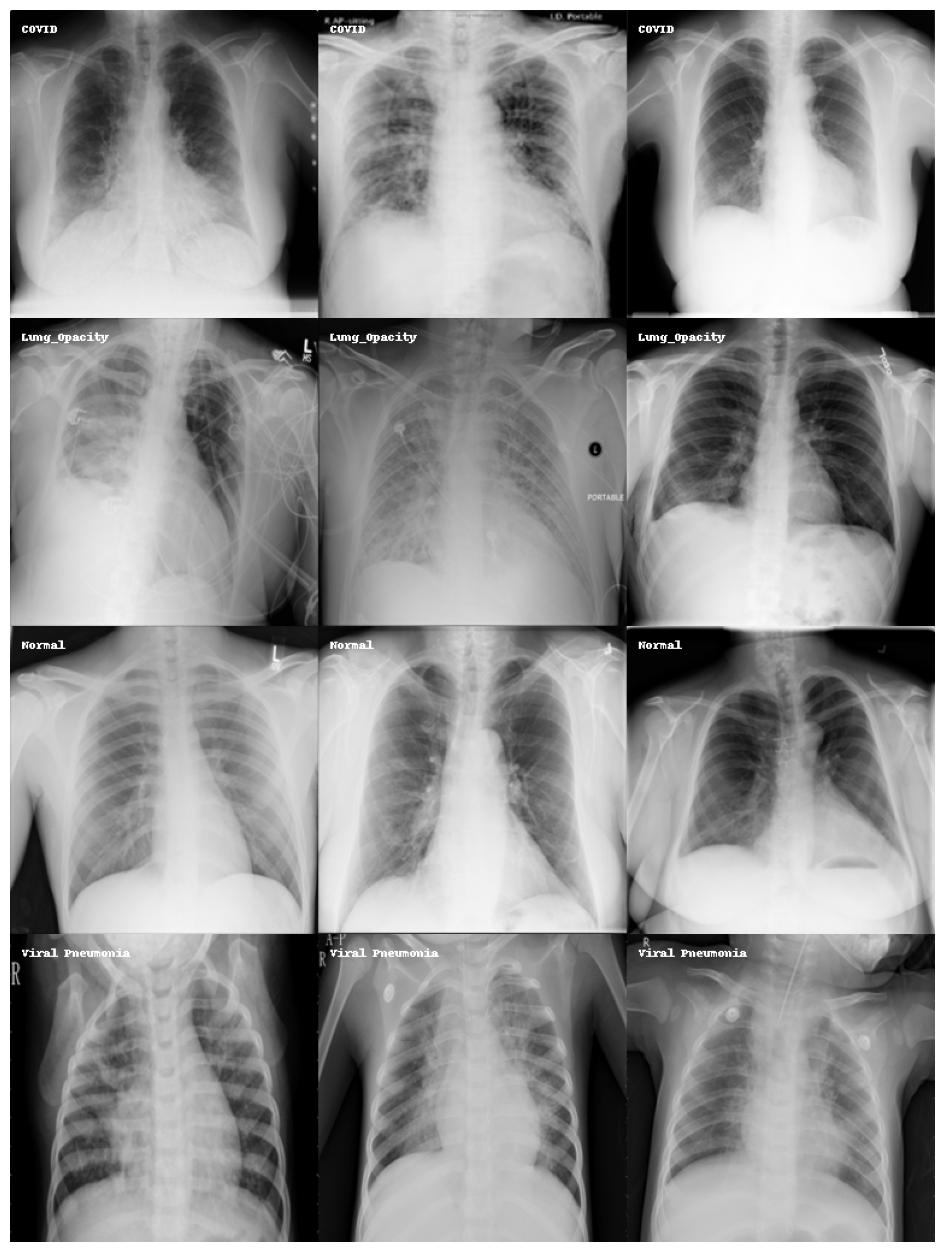

In [14]:
# 随机抽取检查数据集是否正确导入
import random
from PIL import ImageDraw, ImageFont, Image
import matplotlib.pyplot as plt
import numpy as np

def show_examples(dataset, seed: int = 1234, examples_per_class: int = 3, size=(256, 256)):
    random.seed(seed)
    torch.manual_seed(seed)

    categories = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    w, h = size
    grid = Image.new('RGB', size=(examples_per_class * w, len(categories) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.load_default()

    for label_id, label in enumerate(categories):
        # 从数据集中筛选特定类别的样本
        class_samples = [s for s in dataset.samples if s[2] == label]
        random.shuffle(class_samples)
        selected_samples = class_samples[:examples_per_class]

        for i, (img_path, _, _) in enumerate(selected_samples):
            image = Image.open(img_path).convert('RGB').resize(size)
            box = (i * w, label_id * h)
            grid.paste(image, box)
            draw.text((box[0] + 10, box[1] + 10), label, (255, 255, 255), font=font)

    return grid

# 显示图像网格
grid_image = show_examples(dataset, seed=random.randint(0, 1337), examples_per_class=3)
plt.figure(figsize=(32, 16))
plt.imshow(np.array(grid_image))
plt.axis('off')
plt.show()


In [13]:
# 使用DataLoader加载数据
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

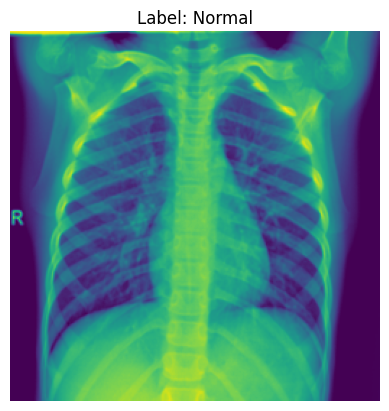

In [16]:
# 从data_loader中展示图像
import matplotlib.pyplot as plt
from torchvision import transforms


data_iter = iter(data_loader)
images, masks, labels = next(data_iter)

# 展示的图像（第一个图像）
image_to_show = images[0]

# 将张量转换回PIL图像
# 将张量从[0, 1]范围转换回[0, 255]范围，并改变维度顺序
image_to_show = image_to_show.numpy().transpose(1, 2, 0)  # 转置维度以符合PIL要求
image_to_show = (image_to_show * 255).astype('uint8')  # 转换回[0, 255]范围

# 展示图像
plt.imshow(image_to_show)
plt.title(f"Label: {labels[0]}")
plt.axis('off') 
plt.show()


In [20]:
#载入VIT模型
model_name = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name)